# 1) 기본 세팅

* 데이터는 업로드하지 않을 예정입니다.

In [ ]:
from google.colab import drive
drive.mount("./MyDrive")

In [ ]:
cd MyDrive/'My Drive'/blomming

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install statsmodels --upgrade

In [4]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [59]:
from typing import List, Dict, Iterable, Tuple, Callable, NamedTuple, Optional, TypeVar
from typing import Optional
from collections import Counter
import random
import math
import enum
import re
import csv
from dateutil.parser import parse
import datetime
import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import xgboost
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

PandasDataFrame = TypeVar('pandas.DataFrame')

plt.figure(figsize=(22, 17))
plt.rc('font', family='NanumBarunGothic') 
sns.set(style='whitegrid', font_scale=1, rc = {'figure.figsize':(22, 17)}, font='NanumBarunGothic')

def pprint(*ss) -> None :  
    print(*ss, '\n')
    
# DF 0의 갯수 출력
def print_num_of_zeros(df: PandasDataFrame) -> None : 
    print("\n================0의 갯수================\n")
    for column in df.columns :
        mask = (df[column] == 0) 
        print (column, ":", sum(mask))

# DF nan 갯수 출력
def print_num_of_nans(df: PandasDataFrame) -> None: 
    print("\n================Nan의 갯수================\n")
    print(df.isna().sum())

# 0 제거 (listwise)
def del_zero_listwise(df: PandasDataFrame) -> PandasDataFrame :
    print_num_of_zeros(df)
    df_listwise = df.copy()
    for column in df_listwise.columns : 
        df_listwise.mask(df_listwise[column] == 0, np.nan, inplace = True)

    print("\n================0을 모두 제거================\n")
    print("nan(0)의 갯수 : ", df_listwise.isna().sum())
    df_listwise.dropna(inplace = True)
    pprint("\ndrop 후 nan(0)의 갯수 : ", df_listwise.isna().sum())
    return df_listwise

# ra : regression analysis
def make_ra_df(base: PandasDataFrame, file_list: List[str]) -> PandasDataFrame :
    temp_base_df = base
    key_list = ['기준_년_코드', '기준_분기_코드','상권_코드']
    base_features = temp_base_df.columns.to_list()

    for file_name in file_list :
        join_df = pd.read_csv('./RA_dataset/' + file_name + '.csv')
        # pprint(join_file)

        join_features = [feature for feature in join_df.columns.to_list() if feature not in base_features or feature in key_list]
        join_df = join_df[join_features]
        # pprint(join_df)

        temp_base_df = pd.merge(temp_base_df, join_df, how='left', on=key_list)
        temp_base_df.dropna(inplace=True)
        # pprint(temp_base_df.info())
        
        not_int_list = ['상권_변화_지표', '상권_변화_지표_명'] + key_list
        convert_features = {feature : 'int64' for feature in join_features if feature not in not_int_list} 
        temp_base_df = temp_base_df.astype(convert_features)
        print(f'\n기준이 되는 DF에 {file_name} 추가한 결과 (left merge / drop_na 실행)\n')
        pprint(temp_base_df.info())
        # print_num_of_zeros(temp_base_df)
    return temp_base_df

# df의 이상치를 제거, standard scaler 적용하고 분기당 매출 금액에 log10을 적용
def make_scaled_df (df:PandasDataFrame, feature_lists:List[str], flag:bool) -> PandasDataFrame :
    copied_df = df.copy()
    copied_df = copied_df.reset_index()
    copied_df.drop(labels='index', axis=1, inplace=True)
    print("초기 상태 :")
    pprint(copied_df.info())

    if flag : 
        # 1. 이상치 제거
        median_list = copied_df.median()[['분기당_매출_금액_per_점포', '점포수', '총_생활인구_수']].to_list()
        # print(median_list)]

        masks = iter([(copied_df['분기당_매출_금액_per_점포'] >= median_list[0]) & (copied_df['점포수'] >= median_list[1]) & (copied_df['총_생활인구_수'] < median_list[2]), 
                                (copied_df['분기당_매출_금액_per_점포'] >= median_list[0]) & (copied_df['점포수'] < median_list[1]) & (copied_df['총_생활인구_수'] < median_list[2]),
                                (copied_df['분기당_매출_금액_per_점포'] < median_list[0]) & (copied_df['점포수'] >= median_list[1]) & (copied_df['총_생활인구_수'] >= median_list[2])])
        for mask in masks : 
            copied_df = copied_df[~mask]
            # print("\n마스크(이상치 제거) 적용 후 :")
            # pprint(copied_df.info())

    # 2. scaler & log10 적용
    ss_copied_df = copied_df[feature_lists]
    scaler = StandardScaler()
    scaler.fit(ss_copied_df)
    ss_copied_df = scaler.transform(ss_copied_df)
    ss_copied_df = pd.DataFrame(data=ss_copied_df, columns=feature_lists)

    if flag : 
        oh_df = pd.get_dummies(copied_df['상권_구분_코드_명']).reset_index().drop('index', axis=1)
        oh_df.drop('관광특구', axis=1, inplace=True) # 가장 표본이 적음
        revenue_df = np.log10(copied_df['분기당_매출_금액'].reset_index().drop('index', axis=1))
        returned_df = pd.concat([ss_copied_df, oh_df], axis=1)
        returned_df = pd.concat([returned_df, revenue_df], axis=1)
    else : 
        revenue_df = np.log10(copied_df['분기당_매출_금액'].reset_index().drop('index', axis=1))
        returned_df = pd.concat([ss_copied_df, revenue_df], axis=1)
    return returned_df

<Figure size 1584x1224 with 0 Axes>

## Key 설정

In [6]:
# 행정동 코드
H_DNG  = gc.open('행정동코드_매핑정보_20200325').sheet1
RSED = gc.open('행정동코드_매핑정보_20200325').worksheet("유입지코드")
H_DNG_rec = H_DNG.get_all_values()
RSED_rec = RSED.get_all_values()

# ['통계청행정동코드', '행자부행정동코드', '시도명', '시군구명', '행정동명']
H_DNG_DF = pd.DataFrame.from_records(H_DNG_rec[1:])
H_DNG_DF.rename(columns=H_DNG_DF.iloc[0], inplace = True)
H_DNG_DF.drop(H_DNG_DF.index[0], inplace = True)

# ['유입지코드', '시군구명', '행정동명']
RSED_DF = pd.DataFrame.from_records(RSED_rec)
RSED_DF.rename(columns=RSED_DF.iloc[0], inplace = True)
RSED_DF.drop(RSED_DF.index[0], inplace = True)

H_DNG_DF = pd.merge(H_DNG_DF, RSED_DF, how='left', left_on = "CT_NM", right_on="RESC_CT_NM")
H_DNG_DF.drop(["RESD_DO_NM", "RESC_CT_NM"], axis = 1, inplace = True)

# ['통계청행정동코드', '행자부행정동코드', '시도명', '시군구명', '행정동명', '유입지코드']
H_DNG_DF.head()

,H_SDNG_CD,H_DNG_CD,DO_NM,CT_NM,H_DNG_NM,RESD_CD
0,1101053,11110530,서울,종로구,사직동,11110
1,1101054,11110540,서울,종로구,삼청동,11110
2,1101055,11110550,서울,종로구,부암동,11110
3,1101056,11110560,서울,종로구,평창동,11110
4,1101057,11110570,서울,종로구,무악동,11110


In [7]:
# 서비스 업종 코드
SERVICE_DF = pd.read_csv('./dataset/CODE_SERVICE.csv')
SERVICE_DF.head()

,서비스_업종_코드,서비스_업종_코드_명
0,CS100001,한식음식점
1,CS100002,중식음식점
2,CS100003,일식음식점
3,CS100004,양식음식점
4,CS100005,제과점


In [8]:
# 상권 코드
AREA = pd.read_csv('./dataset/CODE_AREA.csv') # 상권 코드
AREA.head()

,기준_년_코드,시군구_코드,행정동_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명
0,2018,11110,11110615,U,관광특구,1001494,종로?청계 관광특구
1,2018,11110,11110650,A,골목상권,1000010,성균관로5길
2,2018,11110,11110710,A,골목상권,1000011,숭인동길
3,2018,11110,11110515,A,골목상권,1000012,옥인길
4,2018,11110,11110615,A,골목상권,1000013,율곡로10길


# 2) 코로나 이전과 이후의 산업 변화 확인

* 지난해 3분기 서울시 외식업 개폐업률 통계에 따르면, 서울시 25개 자치구 가운데 강서·강동 등 7개 지역에서 전년 동기보다 개업률이 상승하고 폐업률이 하락

* 이같은 현상은 비교적 서울 외곽 지역에 있는 구로·은평·강동 지역에 그 수혜가 특히 집중됐다. 

* 차별화 장세 속 경쟁력을 강화한 지역은 기존의 서울 주요 상권인 강남·종로·신촌 등을 제외한 비교적 외곽 지역에 분포하고 있다. 
    * 전통적인 중심 상권지로 보기 힘든 강서·양천·영등포·도봉 등 지역들도 전년대비 개업률 상승폭(%포인트)가 폐업률 상승폭을 압도했다.

* 전문가들은 이같은 도심 외곽 외식업계의 선방에 대해 지역 주민을 중심으로 단골 장사에 나서고 배달 서비스 등을 강화하며 자생력을 높인 결과일 수 있다고 보고 있다.

## 코로나 이후 서울의 골목 상권 분석

In [9]:
# 매출
C_GOLMOK_REVENUE = pd.read_csv('./dataset/코로나_이후/코로나_상권배후지_추정매출_가설용.csv') 
GOLMOK_REVENUE_L = pd.read_csv('./dataset/코로나_이전/생활인구_총_상권배후지_추정매출.csv') # L : Living
GOLMOK_REVENUE_WR = pd.read_csv('./dataset/코로나_이전/직장_상주인구_총_상권배후지_추정매출.csv') # W : Work / R : Resident

C_GOLMOK_REVENUE.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,분기당_매출_금액,주중_매출_금액,주말_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,점포수,총_직장_상주인구_수
0,2020,2,A,골목상권,1000001,계동길,CS100010,3461524529,2250783829,1210740700,1482709,200447368,1030049247,1264757387,922085989,42701829,1201740769,2148887612,23899389,1312512702,1092836579,463823126,325213626,132342960,13700,10172,3528,5376,2511,2865,1141014,583250,557762,78,19076
1,2020,2,A,골목상권,1000002,난계로27길,CS100010,1163709493,923370492,240339001,29258,220872203,444578948,282125810,188837113,27266161,483886001,542610460,9069003,284058356,313376084,214938983,136767840,68286196,11773,6288,5485,11539,5772,5767,3840240,1915251,1924988,49,23312
2,2020,2,A,골목상권,1000003,돈화문로11가길,CS100010,5283615306,3739014869,1544600437,25969962,460657733,1549015736,1628745731,1340978122,278248022,1978234776,2949444037,38287128,1847001078,1437192384,704614952,623713406,276869869,39506,26181,13325,3443,2013,1430,1821741,1049214,772527,136,42949
3,2020,2,A,골목상권,1000004,명륜길,CS100010,113198183,84031998,29166185,0,12624615,40563714,29091347,27453318,3465189,52850191,51879409,1223024,50800777,14412839,13842961,14901386,9548616,1696,957,739,8913,4397,4516,3030723,1438553,1592170,20,10609
4,2020,2,A,골목상권,1000005,백석동길,CS100010,618024114,338852296,279171818,147479,5092391,151934722,266781777,178815661,15252084,254820141,338943665,1894518,136410032,169700209,113172192,124020683,48566171,4252,2472,1780,6068,2912,3156,497428,236907,260522,13,10320


In [ ]:
# C_GOLMOK_REVENUE.info()

In [ ]:
df_CGR = C_GOLMOK_REVENUE.drop(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드'], axis = 1)
df_CGR.head()

In [ ]:
df_CGR_listwise = del_zero_listwise(df_CGR)
# df_CGR_listwise.info()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 1.0, '코로나 이후 / 서울 총합 / 골목 상권')

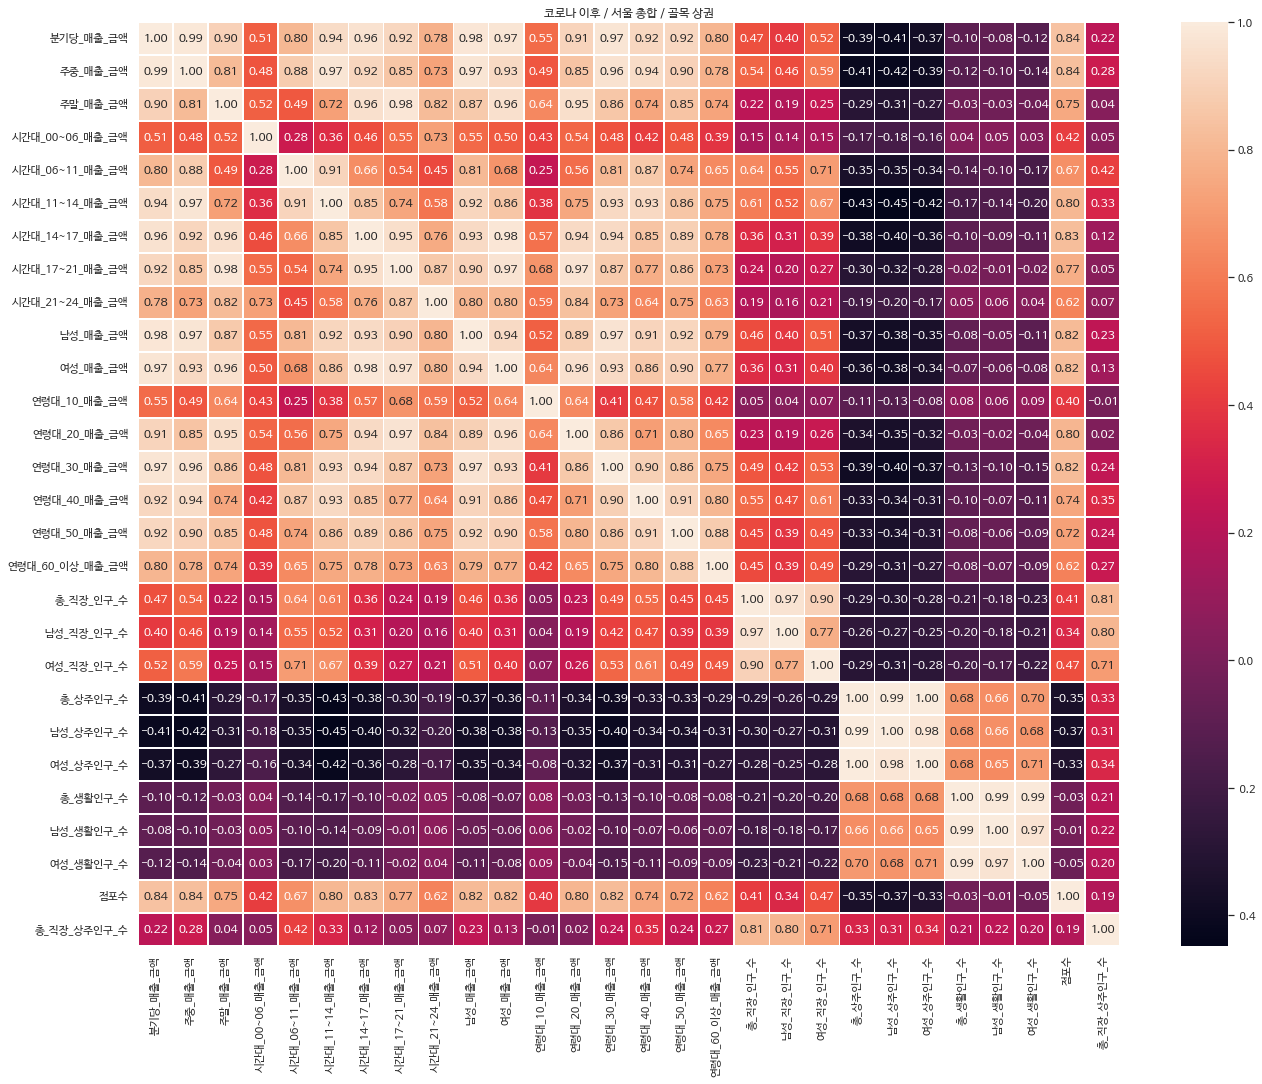

In [13]:
PCC_CGR_listwise = df_CGR_listwise.corr(method='pearson') #Pearson Correlation Coefficient 피어슨 상관계수

h1 = sns.heatmap(PCC_CGR_listwise ,linewidths=.5, annot=True, fmt=".2f")
h1.set_title("코로나 이후 / 서울 총합 / 골목 상권")

## 코로나 이전 서울의 골목 상권 분석

* 생활인구는 18년 1분기 이후부터 데이터 존재



### 직장 인구, 상주 인구 분석

In [14]:
GOLMOK_REVENUE_WR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21147 entries, 0 to 21146
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년_코드          21147 non-null  int64 
 1   기준_분기_코드         21147 non-null  int64 
 2   상권_구분_코드         21147 non-null  object
 3   상권_구분_코드_명       21147 non-null  object
 4   상권_코드            21147 non-null  int64 
 5   상권_코드_명          21147 non-null  object
 6   서비스_업종_코드        21147 non-null  object
 7   분기당_매출_금액        21147 non-null  int64 
 8   주중_매출_금액         21147 non-null  int64 
 9   주말_매출_금액         21147 non-null  int64 
 10  월요일_매출_금액        21147 non-null  int64 
 11  화요일_매출_금액        21147 non-null  int64 
 12  수요일_매출_금액        21147 non-null  int64 
 13  목요일_매출_금액        21147 non-null  int64 
 14  금요일_매출_금액        21147 non-null  int64 
 15  토요일_매출_금액        21147 non-null  int64 
 16  일요일_매출_금액        21147 non-null  int64 
 17  시간대_00~06_매출_금액  21147 non-null

In [ ]:
df_GRWR = GOLMOK_REVENUE_WR.drop(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드'], axis = 1)
# df_GRWR.head()

In [ ]:
df_GRWR_listwise = del_zero_listwise(df_GRWR)
# df_GRWR_listwise.info()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 1.0, '코로나 이전 / 서울 총합 / 골목 상권 / 직장_상주')

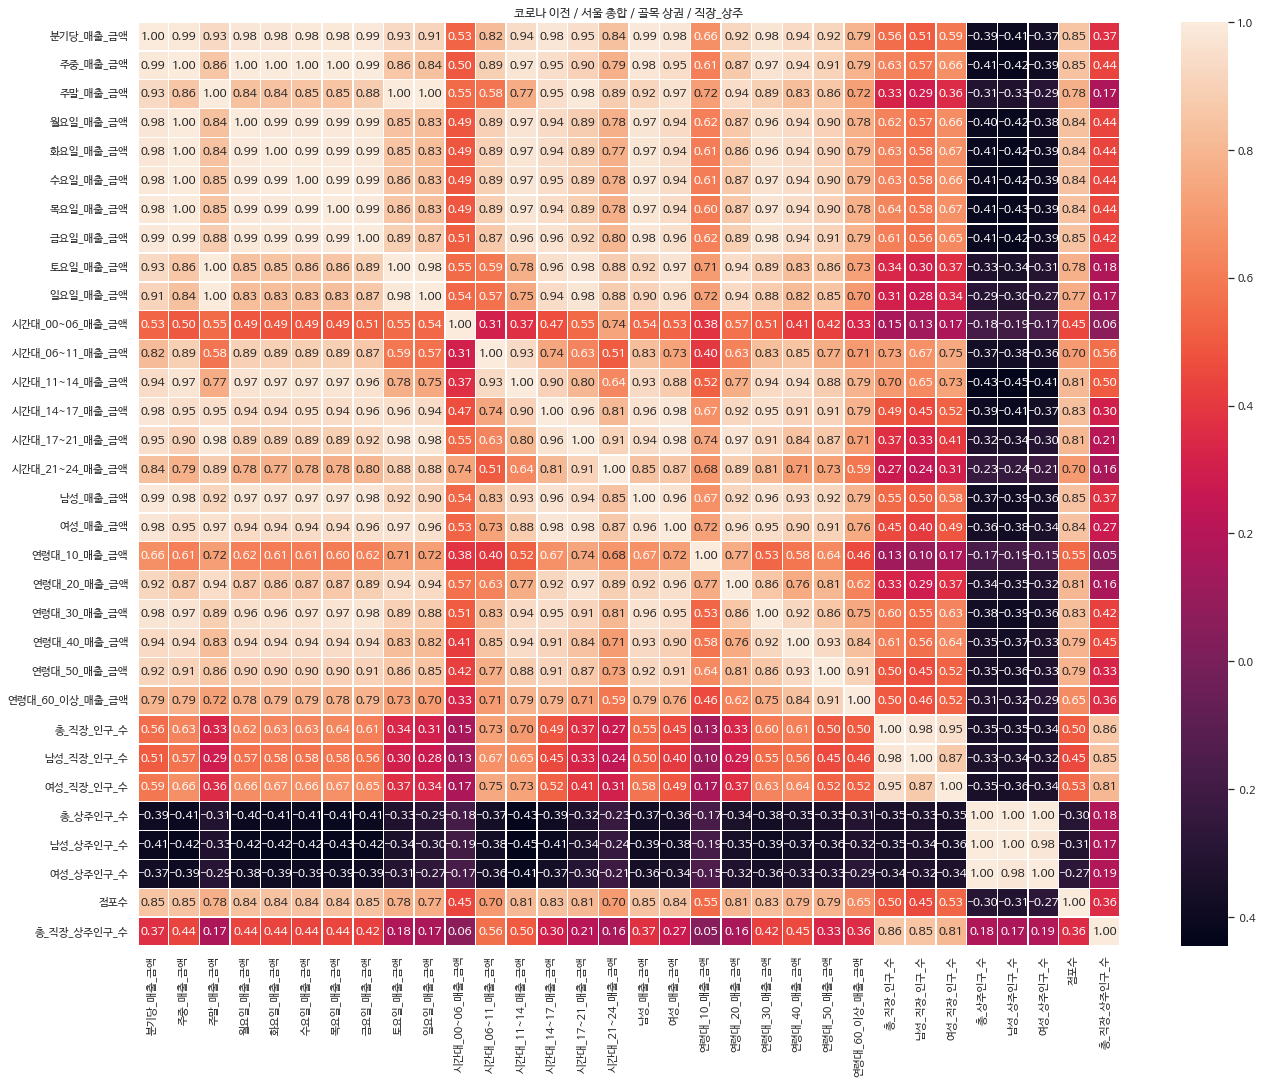

In [17]:
PCC_GRWR_listwise = df_GRWR_listwise.corr(method='pearson')

h2 = sns.heatmap(PCC_GRWR_listwise ,linewidths=.5, annot=True, fmt=".2f")
h2.set_title("코로나 이전 / 서울 총합 / 골목 상권 / 직장_상주")

### 생활 인구 분석

In [18]:
GOLMOK_REVENUE_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9063 entries, 0 to 9062
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년_코드          9063 non-null   int64 
 1   기준_분기_코드         9063 non-null   int64 
 2   상권_구분_코드         9063 non-null   object
 3   상권_구분_코드_명       9063 non-null   object
 4   상권_코드            9063 non-null   int64 
 5   상권_코드_명          9063 non-null   object
 6   서비스_업종_코드        9063 non-null   object
 7   분기당_매출_금액        9063 non-null   int64 
 8   주중_매출_금액         9063 non-null   int64 
 9   주말_매출_금액         9063 non-null   int64 
 10  월요일_매출_금액        9063 non-null   int64 
 11  화요일_매출_금액        9063 non-null   int64 
 12  수요일_매출_금액        9063 non-null   int64 
 13  목요일_매출_금액        9063 non-null   int64 
 14  금요일_매출_금액        9063 non-null   int64 
 15  토요일_매출_금액        9063 non-null   int64 
 16  일요일_매출_금액        9063 non-null   int64 
 17  시간대_00~06_매출_금액  9063 non-null   

In [ ]:
df_GRL = GOLMOK_REVENUE_L.drop(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드'], axis = 1)
# df_GRL.head()

In [ ]:
df_GRL_listwise = del_zero_listwise(df_GRL)
#df_GRL_listwise.info()

Text(0.5, 1.0, '코로나 이전 / 서울 총합 / 골목 상권 / 생활')

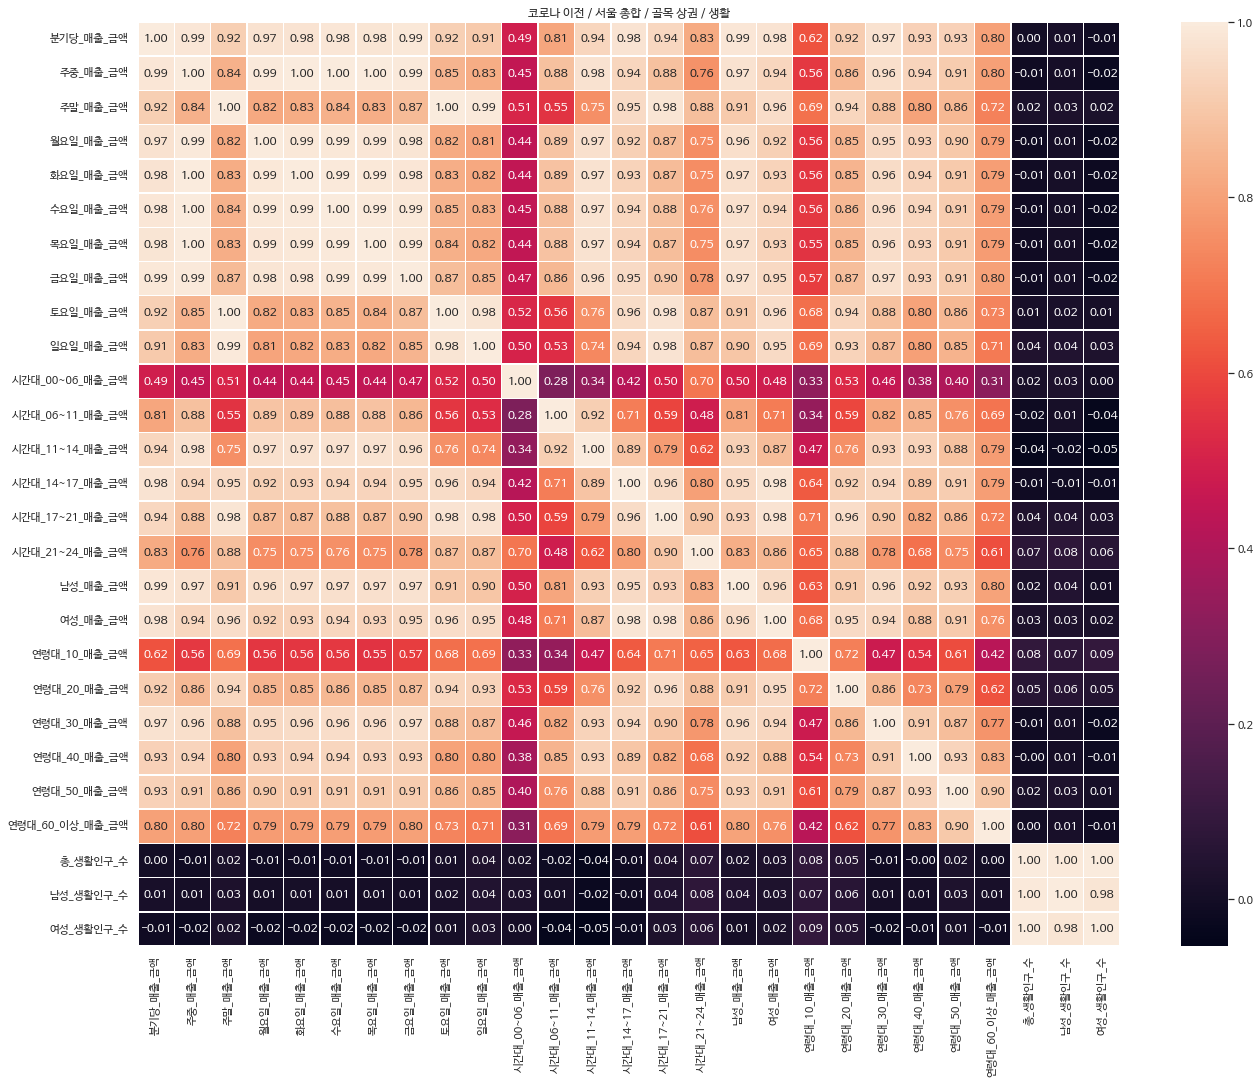

In [58]:
PCC_GRL_listwise = df_GRL_listwise.corr(method='pearson')

h3 = sns.heatmap(PCC_GRL_listwise ,linewidths=.5, annot=True, fmt=".2f")
h3.set_title("코로나 이전 / 서울 총합 / 골목 상권 / 생활")

* 분석 결과를 비교해보면 생활인구(거주인원), 유동인구(그 지역에 왕래하는 인원), 직장인구와 매출간의 상관 관계 값이 변화한 것을 확인할 수 있다.

# 3) 매출 회귀 분석

* 골목 상권을 바탕으로 한 기존 분석에 따르면 코로나 이전과, 코로나 이후 각 독립변수들과 종속변수 사이에 **상관관계가 변했음**을 확인할 수 있었음

* 매출액을 예측하기 위해 매출 및 창업지 선정과 관련된 국-내외 다섯 개의 논문을 분석
    * 상권, 상권 배후지, 통제 변수 등 총 64개의 feature를 수집
    * 매출 예측에 필요한 feature만 선정하기 위해 위의 논문들과 서브스트리트 전략 등의 창업과 관련된 이론을 참고하여 15 개의 가설을 검증
        * ex 1) 업계 최고 프랜차이즈 근처를 입지로 선호, 폐점률은 1%에 불과.
        * ex 2) 여성이 남성보다 매출에 영향을 많이 주고, 여성 유동 인원이 증가하는 지역은 매출이 증가한다.
        * ex 3) 골목상권 내에서 소상공인의 주요 업종(소매업, 음식업) 간에는 마이너스의 상관관계를 보인다.
        * ex 4) 골목상권 내에서 소상공인의 주요 업종(소매업, 음식업) 간에는 마이너스의 상관관계를 보인다.
    * 이를 통해 target과 상관관계가 높고 feature 간의 상관관계는 적은 13개의 feature 추출해냄.
    
* 종속 변수 : 매출액(log)

* 독립 변수 : 
    1. 상권 특성 : 
        * 매출 비율 : 연령별, 시간대별, 요일별, 성별
        * 인구 : 직장 인구수, 상주 인구수, 생활 인구수, 가구수
        * 점포 : 점포수
        * 상권 : 골목 상권, 전통 시장, 관광 특구, 발달 상권

    2. 상권 배후지 특성 : 
        * 상권 배후지의 인구 : 직장 인구수, 상주 인구수, 생활 인구수
        * 상권 배후지의 아파트 단지 수
        * 상권 배후지의 아파트 평균 시가
        * 상권 배후지의 카페 분기당 매출
        * 상권 배후지의 소득 및 소비 : 원 평균 소득, 소득 구간, 지출 총 금액, 카테고리별 지출 총 금액(의류, 식료품 등)

    3. 통제 변수 : 
        * 개업수, 폐업수
        * 운영 영업 개월 평균
        * 폐업 영업 개월 평균
        * 유사업종, 프랜차이즈 점포수
        * 상권, 상권 배후지의 집객 시설 수 (영화관, 할인점, 병원, 백화점 등 고객을 유입시키는 시설)
        * 지하철, 버스 역 수
        * 상권 변화 지표 (HH:정체, HL:상권축소, LH:상권 확장, LL:다이나믹)

* 임금, 지가 등은 값이 매우 크기 때문에 로그 변환으로 분석 결과의 왜곡을 방지

* 진행했던 분석 내용은 생략

<img src='../images/record.png' width="300" />

In [67]:
# 최종적으로 사용한 feature
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              분기당_매출_금액   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     392.8
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:43:15   Log-Likelihood:                -456.23
No. Observations:                1411   AIC:                             940.5
Df Residuals:                    1397   BIC:                             1014.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.2155      0.125     65.512      0.000       7.969       8.461
일요일_매출_비율           -0.0944      0.010     -9.422      0.000      -0.114      -0.075
여성_매출_비율             0.0447      0.009      4.709      0.000       0.026       0.063
연령대_50_매출_비율        -0.0258      0.010     -2.590      0.010      -0.045      -0.006
연령대_60_이상_매출_비율     -0.0208      0.010     -2.027      0.043      -0.041      -0.001
점포수                  0.2219      0.015     14.436      0.000       0.192       0.252
총_상주인구_수            -0.1406      0.026     -5.312      0.000      -0.193      -0.089
총_가구_수               0.1550      0.027      5.722      0.000       0.102       0.208
총_직장_인구_수           -0.0398      0.014     -2.930      0.003      -0.066      -0.013
총_생활인구_수             0.0070      0.015      0.461      0.645      -0.023       0.037
분기당_매출_금액_per_점포     0.4116      0.012     35.534      0.000       0.389       0.434
골목상권                -0.1935      0.128     -1.515      0.130      -0.444       0.057
발달상권                 0.1097      0.122      0.896      0.371      -0.131       0.350
전통시장                -0.2882      0.132     -2.181      0.029      -0.547      -0.029
==============================================================================
Omnibus:                      161.369   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.385
Skew:                          -0.821   Prob(JB):                     2.33e-53
Kurtosis:                       4.193   Cond. No.                         48.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4) XGBoost 회귀 매출 예측

* 팀원이 진행한 부분
* 정리한 내용 추후 추가할 예정

# 5) 리뷰 분석

* 정리한 내용 추후 추가할 예정